# 等值线的测试代码



/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


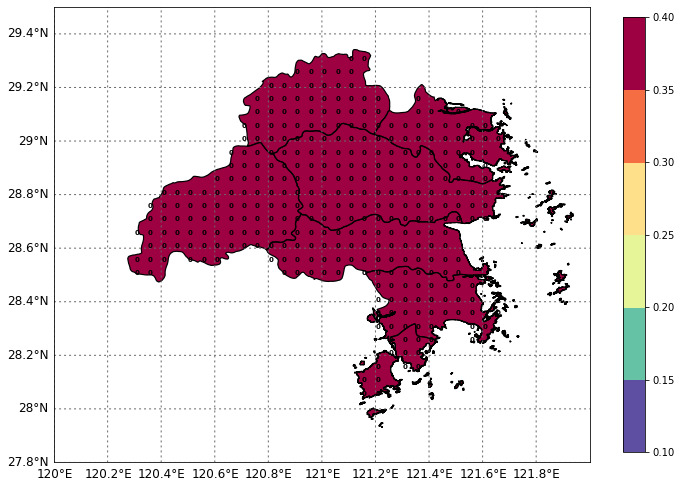

In [1]:
#coding=utf-8
from scipy.interpolate import griddata
import matplotlib as mpl
from math import ceil, floor
from rasterio import features
from affine import Affine
import numpy as np
import xarray as xr
import pandas as pd
import os
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
# from osgeo import gdal
import cartopy.crs as ccrs
import shapefile
from matplotlib.font_manager import FontProperties
# import netCDF4 as nc
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
from math import isnan
import geopandas as gpd
from ncmaps import Cmaps


def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='lat', longitude='lon',
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='lon', latitude='lat')

    return xr_da


def basemask(cs, ax, map, shpfile):

    sf = shapefile.Reader(shpfile)
    vertices = []
    codes = []
    for shape_rec in sf.shapeRecords():
        if shape_rec.record[0] >= 0:  
            pts = shape_rec.shape.points
            prt = list(shape_rec.shape.parts) + [len(pts)]
            for i in range(len(prt) - 1):
                for j in range(prt[i], prt[i+1]):
                    vertices.append(map(pts[j][0], pts[j][1]))
                codes += [Path.MOVETO]
                codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
                codes += [Path.CLOSEPOLY]
            clip = Path(vertices, codes)
            clip = PathPatch(clip, transform = ax.transData)    
    for contour in cs.collections:
        contour.set_clip_path(clip)    



def makedegreelabel(degreelist):
    labels=[str(x)+u'°E' for x in degreelist]
    return labels


def plot_image(lat,lon,value):
    #线性插值
    N = len(value)
    a = []
    b = []
    z = []
    for i in range(N):
        if value[i]!=-9999.0:
            a.append(round(lon[i],2))
            b.append(round(lat[i],2))
            z.append(round(value[i],2))
    lat = np.array(b)
    lon = np.array(a)
    Zi = np.array(z)
    data_max = max(Zi)
    data_min = min(Zi)
    np.set_printoptions(precision = 2)
    x = np.arange(120.0,122.0,0.05)
    #print(x)
    y = np.arange(27.8,29.5,0.05)
    nx0 =len(x)
    ny0 =len(y)
    X, Y = np.meshgrid(x, y)#100*100
    P = np.array([X.flatten(), Y.flatten() ]).transpose()    
    Pi =  np.array([lon, lat ]).transpose()
    Z_linear = griddata(Pi, Zi, P, method = "nearest").reshape([ny0,nx0])
    #绘图
    levels = np.linspace(start = data_min/10.0, stop = data_max/10.0, num = 7)
    self_define_list = [130,144,155,170,185,200,225,235,240,244]
    rgb_file = 'ncl_default'
    #以下是核心api,实质为调用Cmaps基类的listmap()方法
    cmaps = Cmaps('ncl_default',self_define_list).listmap()
    # plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=[12,16]) 
    
    ax = fig.add_subplot(111)
    # plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
    # filepath = "static/data/shpfile/"
    filepath = "/home/liyuan3970/Data/My_Git/web_met/static/data/shpfile/"
    data_xr = xr.DataArray(Z_linear/10.0, coords=[ y,x], 
                        dims=["lat", "lon"])
    shp_da = add_shape_coord_from_data_array(data_xr, filepath+"taizhou.shp", "test")
    awash_da = shp_da.where(shp_da.test<7, other=np.nan)
    m = Basemap(llcrnrlon=120.0,llcrnrlat=27.8,urcrnrlon=122,urcrnrlat=29.5,resolution = None, projection = 'cyl')
    # 设置colorbar
    cbar_kwargs = {'shrink': 0.5}    
    cs = data_xr.plot.contourf(ax=ax, cmap='Spectral_r',levels =levels,cbar_kwargs=cbar_kwargs,add_labels=False)
    m.readshapefile(filepath+'taizhou','taizhou',color='k',linewidth=1.2)
    parallels = np.arange(27.8,29.5,0.2)
    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
    meridians = np.arange(120.0,122.0,0.2)
    m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
    len_lat = len(data_xr.lat.data)
    len_lon = len(data_xr.lon.data)
    for i in range(len_lon-1):
        for j in range(len_lat-1):
            y0 = round(27.8+j*0.05,2)
            x0 = round(120.0+i*0.05,2)
            if not isnan(awash_da.data[j,i]):
                plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")
    basemask(cs, ax, m, filepath+'taizhou')  
lat = [1,2,3,4]    
lon = [1,2,3,4] 
value = [1,2,3,4] 
plot_image(lat,lon,value)


In [14]:
pwd!


'/workspace/liyuan3970/Data/My_Git/web_met/static/data'

# 读取文件的测试

In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
import netCDF4 
import h5py     

def read_data():
        file_path = "/home/liyuan3970/Data/My_Git/web_met/static/data/TZ_self/"        
        file_name = file_path +"20220401/"+'I20220401080000.'+'TMax24'+'.nc'
        f = netCDF4.Dataset(file_name)
        data_xr_nc = f.variables['TMax24']
        lat = f.variables['lat'][:]
        lon = f.variables['lon'][:]
        time = f.variables['time'][:]
          
        # return lat,lon,time,data_xr_nc
read_data()

In [2]:
import xarray as xr
     
def read_data():
        file_path = "/home/liyuan3970/Data/My_Git/web_met/static/data/TZ_self/"        
        file_name = file_path +"20220401/"+'I20220401080000.'+'TMax24'+'.nc'
        f = xr.open_dataset(file_name)
        data_xr_nc = f.variables['TMax24']
        lat = f.variables['lat'][:]
        lon = f.variables['lon'][:]
        time = f.variables['time'][:]
          
        return lat,lon,time,data_xr_nc
lat,lon,time,data_xr_nc = read_data()

lat

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


<xarray.IndexVariable 'lat' (lat: 47)>
array([27.5 , 27.55, 27.6 , 27.65, 27.7 , 27.75, 27.8 , 27.85, 27.9 , 27.95,
       28.  , 28.05, 28.1 , 28.15, 28.2 , 28.25, 28.3 , 28.35, 28.4 , 28.45,
       28.5 , 28.55, 28.6 , 28.65, 28.7 , 28.75, 28.8 , 28.85, 28.9 , 28.95,
       29.  , 29.05, 29.1 , 29.15, 29.2 , 29.25, 29.3 , 29.35, 29.4 , 29.45,
       29.5 , 29.55, 29.6 , 29.65, 29.7 , 29.75, 29.8 ], dtype=float32)
Attributes:
    units:      degrees_north
    long_name:  Latitude

In [5]:
import h5netcdf.legacyapi as netCDF4
import h5netcdf
import h5py
file_path = "/home/liyuan3970/Data/My_Git/web_met/static/data/TZ_self/"        
file_name = file_path +"20220401/"+'I20220401080000.'+'T'+'.nc'

f = h5netcdf.File(file_name,invalid_netcdf=True)
print(f.variables)
lat = f.variables['lat'][:]
# with netCDF4.Dataset(file_name, 'r') as f:
#     print(f)
    # data_xr_nc = f.variables['T']
    # data_xr_nc = f.variables['T']
    # lat = f.variables['lat'][:]
    # lon = f.variables['lon'][:]
    # time = f.variables['time'][:]
    
    
   

OSError: Unable to open file (truncated file: eof = 96, sblock->base_addr = 0, stored_eof = 2048)

# 绘图核心代码函数

In [6]:
import netCDF4 
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import shapefile
import matplotlib as mpl
import xarray as xr
from matplotlib.font_manager import FontProperties
import netCDF4 as nc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
from math import isnan
import geopandas as gpd
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import math
from math import isnan
from scipy.interpolate import griddata
from math import ceil, floor
from rasterio import features
from affine import Affine
'''设计一个画图的类，识别画图类型，并直接出图，数据包含在list列表中，64编码形式存储'''




class plot_tz_product:
    def __init__(self, plot_type,plot_time):
        self.plot_time = plot_time
        self.plot_type = plot_type
        self.time_len = 0
        self.lat,self.lon,self.time,self.data_xr_nc  = self.read_data()
    # 外部函数
    def transform_from_latlon(self,lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale
    
    def rasterize(self,shapes, coords, latitude='lat', longitude='lon',fill=np.nan, **kwargs):
        transform = self.transform_from_latlon(coords[latitude], coords[longitude])
        out_shape = (len(coords[latitude]), len(coords[longitude]))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
        spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
        return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

    def add_shape_coord_from_data_array(self,xr_da, shp_path, coord_name):   
        shp_gpd = gpd.read_file(shp_path)
        shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
        xr_da[coord_name] = self.rasterize(shapes, xr_da.coords, longitude='lon', latitude='lat')
        return xr_da


    def basemask(self,cs, ax, map, shpfile):
        sf = shapefile.Reader(shpfile)
        vertices = []
        codes = []
        for shape_rec in sf.shapeRecords():
            if shape_rec.record[0] >= 0:  
                pts = shape_rec.shape.points
                prt = list(shape_rec.shape.parts) + [len(pts)]
                for i in range(len(prt) - 1):
                    for j in range(prt[i], prt[i+1]):
                        vertices.append(map(pts[j][0], pts[j][1]))
                    codes += [Path.MOVETO]
                    codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
                    codes += [Path.CLOSEPOLY]
                clip = Path(vertices, codes)
                clip = PathPatch(clip, transform = ax.transData)    
        for contour in cs.collections:
            contour.set_clip_path(clip)    



    def makedegreelabel(self,degreelist):
        labels=[str(x)+u'°E' for x in degreelist]
        return labels

    def read_data(self):
        file_path = "/home/liyuan3970/Data/My_Git/web_met/static/data/TZ_self/"        
        file_name = file_path +"20220401/"+'I20220401080000.'+self.plot_type+'.nc'
        f = netCDF4.Dataset(file_name)
        data_xr_nc = f.variables['T']
        lat = f.variables['lat'][:]
        lon = f.variables['lon'][:]
        time = f.variables['time'][:]
        self.time_len = len(time)        
        return lat,lon,time,data_xr_nc
    def plot_img(self,item):
        lat = self.lat
        lon = self.lon
        time = self.time
        data_xr_nc = self.data_xr_nc
        data_xr = xr.DataArray(data_xr_nc[item,:,:],coords=[lat,lon], dims=["lat", "lon"])
        levels = np.linspace(start = 2, stop = 11, num = 7)#[10,20,30,40,50,60,70,80,90,100,110]
        self_define_list = [130,144,155,170,185,200,225,235,240,244]
        rgb_file = 'ncl_default'
        #以下是核心api,实质为调用Cmaps基类的listmap()方法
        cmaps = Cmaps('ncl_default',self_define_list).listmap()
        # plt.rcParams.update({'font.size': 20})
        fig = plt.figure(figsize=[8,8]) 
        ax = fig.add_subplot(111)
        shp_path = "/home/liyuan3970/study_demo/met_plot/Basemap/"
        shp_da = self.add_shape_coord_from_data_array(data_xr, shp_path+"taizhou.shp", "test")
        awash_da = shp_da.where(shp_da.test<7, other=np.nan)
        m = Basemap(llcrnrlon=120.0,
            llcrnrlat=27.8,
            urcrnrlon=122,
            urcrnrlat=29.5,
            resolution = None, 
            projection = 'cyl')
        # 设置colorbar
        cbar_kwargs = {
        #'orientation': 'horizontal',
        # 'label': 'Potential',
        'shrink': 0.5,
        }
        lons, lats = np.meshgrid(lon, lat)
        cs =m.contourf(lons,lats,data_xr,ax=ax, cmap='Spectral_r',levels =levels,cbar_kwargs=cbar_kwargs,add_labels=False)
        m.readshapefile(shp_path+'taizhou','taizhou',color='k',linewidth=1.2)
        parallels = np.arange(27.8,29.5,0.2)
        m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
        meridians = np.arange(120.0,122.0,0.2)
        m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
        len_lat = len(data_xr.lat.data)
        len_lon = len(data_xr.lon.data)
        for i in range(len_lon-1):
            for j in range(len_lat-1):
                y0 = round(27.50+j*0.05,2)
                x0 = round(119.80+i*0.05,2)
                if not isnan(awash_da.data[j,i]):
                    plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")            
        self.basemask(cs, ax, m, shp_path+'taizhou') 
        buffer = BytesIO()
        plt.savefig(buffer,bbox_inches='tight')  
        plot_img = buffer.getvalue()
        imb = base64.b64encode(plot_img) 
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        return imd        
    def multy_plot(self):
        '''返回图片列表'''
        imd_list = []
        for i in range(self.time_len):
            imd = self.plot_img(i)
            imd_list.append(imd)
        return imd_list

    


        

plot_type = 'T'

plot_time = "08"

plot_worker = plot_tz_product(plot_type,plot_time)        
imd_list = plot_worker.multy_plot()        

        

OSError: [Errno -101] NetCDF: HDF error: b'/home/liyuan3970/Data/My_Git/web_met/static/data/TZ_self/20220401/I20220401080000.T.nc'

In [ ]:
imd_list